In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
df = pd.read_csv('./goodreads_reviews_comics_graphic_dropped.csv')
map_title = pd.read_csv('./goodreads_books_comics_graphic_dropped.csv')

In [8]:
maptitle = map_title[['book_id', 'title']].drop_duplicates()

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 542338 entries, 0 to 542337
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   user_id  542338 non-null  object
 1   book_id  542338 non-null  int64 
 2   rating   542338 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 12.4+ MB


In [10]:
df.head()

,user_id,book_id,rating
0,dc3763cdb9b2cae805882878eebb6a32,18471619,3
1,bafc2d50014200cda7cb2b6acd60cd73,6315584,4
2,bafc2d50014200cda7cb2b6acd60cd73,29847729,4
3,bafc2d50014200cda7cb2b6acd60cd73,18454118,5
4,bafc2d50014200cda7cb2b6acd60cd73,2239435,4


In [52]:
df.describe()

,book_id,rating
count,5.423380e+05,542338.000000
mean,1.374005e+07,3.778138
std,1.049608e+07,1.153660
min,3.740000e+02,0.000000
25%,2.707862e+06,3.000000
50%,1.349915e+07,4.000000
75%,2.288631e+07,5.000000
max,3.650849e+07,5.000000


In [11]:
ratings = df[0:10000]

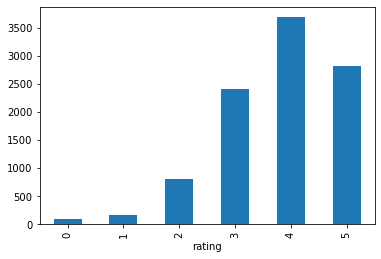

In [12]:
ratings.groupby('rating').count()['user_id'].plot.bar()

In [13]:
ratings_rmv_duplicates = ratings.drop_duplicates()

In [14]:
unwanted_users = ratings_rmv_duplicates.groupby('user_id')['user_id'].count()

In [15]:
unwanted_users = unwanted_users[unwanted_users < 3]
unwanted_users.shape

(312,)

In [16]:
ratings_rmv_duplicates.user_id.isin(unwanted_users.index)

0        True
1       False
2       False
3       False
4       False
        ...  
9995    False
9996    False
9997    False
9998    False
9999    False
Name: user_id, Length: 10000, dtype: bool

In [17]:
unwanted_ratings = ratings_rmv_duplicates[ratings_rmv_duplicates.user_id.isin(unwanted_users.index)]
# Số lượng user có ít hơn 3 đánh giá
unwanted_ratings.shape[0]

397

In [18]:
new_ratings = ratings_rmv_duplicates.drop(unwanted_ratings.index)
new_ratings.shape

(9603, 3)

In [19]:
new_ratings['title'] = map_title.set_index('book_id').title.loc[new_ratings.book_id].values

In [20]:
new_ratings.head()

,user_id,book_id,rating,title
1,bafc2d50014200cda7cb2b6acd60cd73,6315584,4,Spider-Man: The Darkest Hours
2,bafc2d50014200cda7cb2b6acd60cd73,29847729,4,Jim Butcher's Dresden Files: Wild Card #1
3,bafc2d50014200cda7cb2b6acd60cd73,18454118,5,"Deadlock, Vol. 1"
4,bafc2d50014200cda7cb2b6acd60cd73,2239435,4,"All-Star Batman and Robin, the Boy Wonder, Vol. 1"
5,bafc2d50014200cda7cb2b6acd60cd73,13094398,3,"Black Butler, Vol. 12 (Black Butler, #12)"


In [21]:
from surprise import Dataset, Reader

In [22]:
reader = Reader(rating_scale = (0,5))

In [23]:
data = Dataset.load_from_df(new_ratings[['user_id', 'book_id', 'rating']], reader)


In [24]:
trainsetfull = data.build_full_trainset()

In [25]:
print('Number of users: ', trainsetfull.n_users, '\n')
print('Number of items: ', trainsetfull.n_items, '\n')

Number of users:  225 

Number of items:  7380 



In [26]:
from surprise.model_selection import train_test_split

In [27]:
trainset, testset = train_test_split(data, test_size=0.2)

In [28]:
print('Number of users: ', trainset.n_users, '\n')
print('Number of items: ', trainset.n_items, '\n')

Number of users:  225 

Number of items:  6062 



In [29]:
trainset_iids = list(trainset.all_items())

In [30]:
trainset_iids[0:5]

[0, 1, 2, 3, 4]

In [31]:
# Function chuyển đổi inner id về raw id
iid_converter = lambda x: trainset.to_raw_iid(x)
trainset_raw_iids = list(map(iid_converter, trainset_iids))

In [32]:
trainset_raw_iids[0:5]

[18295918, 8601702, 11480909, 8582943, 13183551]

In [33]:
from surprise import KNNBasic

In [34]:
# Số lượng láng giềng sẽ lấy
my_k = 10
# Nếu user không đánh giá đủ số item để đưa ra đánh giá, giá trị trung bình toàn cục sẽ được sử dụng để ước tính
my_min_k = 2
my_sim_option = {
    'name': 'cosine', 'user_based': False
}

In [35]:
algo = KNNBasic(k = my_k, min_k = my_min_k, sim_option = my_sim_option)

In [36]:
algo.fit(trainset)


Computing the msd similarity matrix...
Done computing similarity matrix.


In [37]:
pd.DataFrame(algo.sim)

,0,1,2,3,4,5,6,7,8,9,...,215,216,217,218,219,220,221,222,223,224
0,1.000000,0.325843,0.445312,0.0,0.75,0.25,0.333333,0.282609,0.5,0.666667,...,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,1.0
1,0.325843,1.000000,0.306452,0.0,0.00,0.00,0.500000,0.285714,0.0,0.200000,...,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0
2,0.445312,0.306452,1.000000,0.0,0.00,0.00,0.200000,0.208333,0.0,0.375000,...,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.000000,0.000000,1.0,0.00,0.00,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.750000,0.000000,0.000000,0.0,1.00,0.00,0.000000,0.500000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220,0.000000,0.500000,0.000000,0.0,0.00,0.00,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
221,0.000000,0.000000,0.000000,0.0,0.00,0.00,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
222,0.000000,0.000000,0.000000,0.0,0.00,0.00,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
223,0.000000,0.000000,0.000000,0.0,0.00,0.00,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [38]:
from surprise import accuracy

In [39]:
predictions = algo.test(testset)

In [40]:
accuracy.rmse(predictions)

RMSE: 1.0636


1.0635822500630066

In [41]:
#Testing with cross-validation
from surprise.model_selection import cross_validate

In [42]:
results = cross_validate(
    algo = algo, data = data, measures=['RMSE'], 
    cv=5, return_train_measures=True, verbose=True
    )

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.0471  1.0550  1.0268  1.0836  1.0516  1.0528  0.0182  
RMSE (trainset)   0.8915  0.8883  0.8888  0.8804  0.8772  0.8852  0.0055  
Fit time          0.00    0.00    0.00    0.00    0.00    0.00    0.00    
Test time         0.02    0.02    0.02    0.01    0.01    0.02    0.00    


In [43]:
# Rating ước tính trung bình có thể cao hơn hoặc thấp hơn thực tế khoảng 1 điểm
results['test_rmse'].mean()

1.052809457862967

In [44]:
algo.fit(trainsetfull)

Computing the msd similarity matrix...
Done computing similarity matrix.


In [45]:
pd.DataFrame(algo.sim)

,0,1,2,3,4,5,6,7,8,9,...,215,216,217,218,219,220,221,222,223,224
0,1.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,0.0,1.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.666667
3,0.0,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.100000
4,0.0,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000000
221,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.5,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.000000
222,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000
223,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000


In [46]:
algo.predict(uid = 'bafc2d50014200cda7cb2b6acd60cd73', iid = '18454118')
# r_ui: None tức là user thực tế chưa đánh giá cho item đó
# est: giá trị đánh giá dự đoán của user đó với item tương ứng

Prediction(uid='bafc2d50014200cda7cb2b6acd60cd73', iid='18454118', r_ui=None, est=3.780901801520358, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'})

In [47]:
predictset = trainsetfull.build_anti_testset()
pred = algo.test(predictset)

In [48]:
pred_df = pd.DataFrame(pred)
pred_df

,uid,iid,r_ui,est,details
0,bafc2d50014200cda7cb2b6acd60cd73,15984307,3.780902,3.780902,"{'was_impossible': True, 'reason': 'Not enough..."
1,bafc2d50014200cda7cb2b6acd60cd73,25243735,3.780902,4.000000,"{'actual_k': 2, 'was_impossible': False}"
2,bafc2d50014200cda7cb2b6acd60cd73,62953,3.780902,3.780902,"{'was_impossible': True, 'reason': 'Not enough..."
3,bafc2d50014200cda7cb2b6acd60cd73,2568939,3.780902,3.780902,"{'was_impossible': True, 'reason': 'Not enough..."
4,bafc2d50014200cda7cb2b6acd60cd73,418149,3.780902,3.780902,"{'was_impossible': True, 'reason': 'Not enough..."
...,...,...,...,...,...
1650892,9da326d91927727ed8ae43461f80b08c,9748281,3.780902,3.780902,"{'was_impossible': True, 'reason': 'Not enough..."
1650893,9da326d91927727ed8ae43461f80b08c,14623253,3.780902,3.780902,"{'was_impossible': True, 'reason': 'Not enough..."
1650894,9da326d91927727ed8ae43461f80b08c,203944,3.780902,3.780902,"{'was_impossible': True, 'reason': 'Not enough..."
1650895,9da326d91927727ed8ae43461f80b08c,42261,3.780902,3.780902,"{'was_impossible': True, 'reason': 'Not enough..."


In [49]:
def get_top_n(pred, uid, rating, n=5):
    recommendData = pred[(pred['est']>rating)&(pred['uid']==uid)].sort_values(by=['est'], ascending=False).head(n)
    return recommendData.merge(map_title, left_on='iid', right_on='book_id')[['uid', 'book_id', 'title', 'est']]

In [50]:
get_top_n(pred_df, 'bafc2d50014200cda7cb2b6acd60cd73', 3.0, 5)

,uid,book_id,title,est
0,bafc2d50014200cda7cb2b6acd60cd73,28862528,"Saga, Vol. 6 (Saga, #6)",5.0
1,bafc2d50014200cda7cb2b6acd60cd73,43722,"Fell, Feral City",5.0
2,bafc2d50014200cda7cb2b6acd60cd73,30842268,"Gwenpool, the Unbelievable, Vol. 2: Head of M....",5.0
3,bafc2d50014200cda7cb2b6acd60cd73,26085,Identity Crisis,5.0
4,bafc2d50014200cda7cb2b6acd60cd73,31247173,"Kill or Be Killed, Vol. 1",5.0
